In [152]:
import numpy as np 
import xarray as xr 
import scipy 
import matplotlib.pyplot as plt  # Plotting library
import cartopy, cartopy.crs as ccrs  # Plot maps
import random 
import satcmaps as cmaps
import image_retrieval as img
import goesRequest2 as goes 

G16 = -75.2
G18 = -137.2
REGIONS = {'NATL' : ([-100, -10, 0, 65], (18, 9)),
           'WATL' : ([-100, -50, 2.5, 35], (18, 9)),
           'MDR'  : ([-65, -15, 5, 27.5], (16, 6)),
           'US'   : ([-130, -60, 20, 60], (18, 9)),
           'WUS'  : ([-140, -100, 25, 57.5], (18, 9)),
           'SWATL': ([-95, -55, 10, 45], (18, 9)),
           'GOM'  : ([-100, -75, 15, 32.5], (18, 9)),
           'EPAC' : ([-140, -80, 0, 30], (16, 6)),
           'CPAC' : ([-179, -119, 0, 30], (16, 6)),
           'NPAC' : ([-179, -99, 20, 70], (24, 8)),
           'TPAC' : ([-179, -79, 0, 50], (16, 6)),
           'WPAC' : ([105, 170, 0, 45], (18, 9)),
           'WMDR' : ([110, 160, 5, 27.5], (16, 6)),
           'PHIL' : ([105, 140, 5, 26], (16, 6)),
           'AUS'  : ([100, 165, -45, 0], (18, 9)),
           'SPAC' : ([139, 199, -45, 0], (18, 9)),
           'SCPAC': ([-189, -129, -45, 0], (18, 9)),
           'SEPAC': ([-159, -79, -45, 0], (18, 9)),
           'ENSO' : ([-189, -79, -25, 25], (16, 6)),
           'EQ' : ([69, 179, -25, 25], (16, 6))}


In [2]:
def calculate_degrees(dataset): # Adapted from https://www.star.nesdis.noaa.gov/atmospheric-composition-training/python_abi_lat_lon.php
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = dataset['x']  # E/W scanning angle in radians
    y_coordinate_1d = dataset['y']  # N/S elevation angle in radians
    projection_info = dataset['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height + projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')

    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return abi_lat, abi_lon


In [3]:
def reproject(dataset, lats, lons, pos):   
    size = 5         
    IR = dataset['CMI'].data - 273.15
                        
    # Extents and interpolation for IR
    minimglat = pos[0] - size
    maximglat = pos[0] + size
    minimglon = pos[1] - size
    maximglon = pos[1] + size
    res = 0.0179985  # degrees resolution at nadir
    grid = np.meshgrid(np.arange(minimglat, maximglat, res), np.arange(minimglon, maximglon, res))
    
    lats = lats.flatten()
    lons = lons.flatten()
    IR = IR.flatten()
    
    # Fix shape issue for boolean conditions
    floater_IR = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
                    np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(IR))

    gridded_data = scipy.interpolate.griddata((lats[floater_IR], lons[floater_IR]), IR[floater_IR], (grid[0], grid[1]), method='linear')
    
    return grid[1], grid[0], gridded_data

In [4]:
def stormir(lons, lats, data, pos, time, cmap = 'irg'):
    try:
        lat, lon = pos
        extent = [lon - 5, lon + 5, lat - 5, lat + 5]
        figSize = (18, 9)
    except:
        extent, figSize = REGIONS[pos.upper()]
        lon = (extent[0] + extent[1]) / 2

    try:
        if pos.lower() in ['spac', 'scpac', 'enso']:
            goes.makeMap(extent, figSize, 180)
    except:
        goes.makeMap(extent, figSize) 
    
    if cmap.lower() == 'random':
        rand = random.randrange(0, len(cmaps.irtables.keys()), 1)
        cmap = list(cmaps.irtables.keys())[rand]
        
    cmap, vmax, vmin = cmaps.irtables[cmap.lower()]

    plt.pcolormesh(lons, lats, data, vmin = vmin, vmax = vmax, cmap = cmap)
    plt.colorbar(orientation = 'vertical', aspect = 50, pad = .02)
    plt.title(f'GOES-16 Channel 13 Brightness Temperature\nSatellite Image: {time}' , fontweight='bold', fontsize=10, loc='left')
    plt.title(f'2km\nDeelan Jariwala', fontsize=10, loc='right')
    plt.savefig(r"C:\Users\deela\Downloads\stormir.png", dpi = 250, bbox_inches = 'tight')
    plt.show()
    plt.close()
    #data[0].close()

In [153]:
year = 2025
month = 8
day = 16
time = '1340'

filename = img.getDataGOES('19', year, month, day, time, '13')
dataset = xr.open_dataset(r"C:\Users\deela\Downloads\\" + filename + ".nc")

GOES-19 data downloaded for 8/16/2025 at 1340z


In [154]:
allLats, allLons = calculate_degrees(dataset)

In [155]:
lons, lats, data = reproject(dataset, allLats, allLons, (19.6, -62.1))

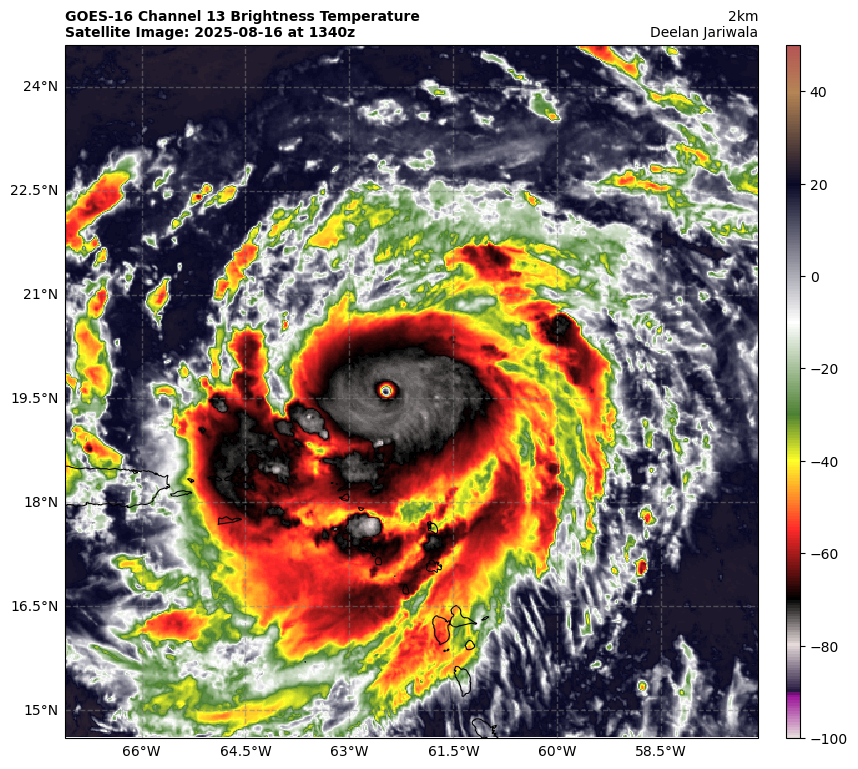

In [157]:
stormir(lons, lats, data, (19.6, -62.1), f'{str(year)}-{str(month).zfill(2)}-{str(str(day).zfill(2))} at {time}z')

In [280]:
def rePoPolar(dataset, lats, lons, center = None):
    if center is None:
        clat = np.nanmean(lats)
        clon = np.nanmean(lons)
    else:
        clat, clon = center
    print(clat, clon)

    R = 6371.0
    cphi = np.cos(np.radians(clat))
    x = R * np.radians(lons - clon) * cphi
    y = R * np.radians(lats - clat)

    r = np.sqrt(x**2 + y**2)
    t = np.arctan2(y, x)

    rBins = np.linspace(0, 500, 500)
    tBins = np.linspace(np.nanmin(t), np.nanmax(t), 200)

    R, T = np.meshgrid(rBins, tBins)
    newX, newY = R * np.cos(T), R * np.sin(T)
    gridded_data = scipy.interpolate.griddata((x.flatten(), y.flatten()), dataset.flatten(), (newX.flatten(), newY.flatten()), method='nearest')

    polar = xr.Dataset(
        {
            'data': (('r', 'theta'), gridded_data.reshape(R.shape).transpose())
        },
        coords={
            'r': rBins,
            'theta': tBins
        }
    )

    polar = polar.sel(r = slice(0, 500))
    polar = polar.interp(r = np.arange(0, 500, 1))

    return x, y, polar['data']


19.6 -62.45


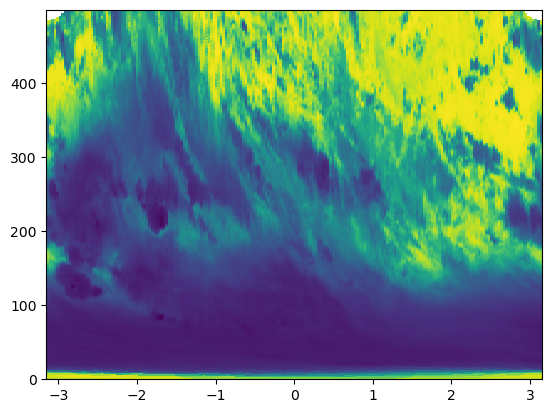

In [281]:
xkm, ykm, polar = rePoPolar(data, lats, lons, center = (19.6, -62.45))
plt.pcolormesh(polar.theta, polar.r, polar.values)
plt.show()

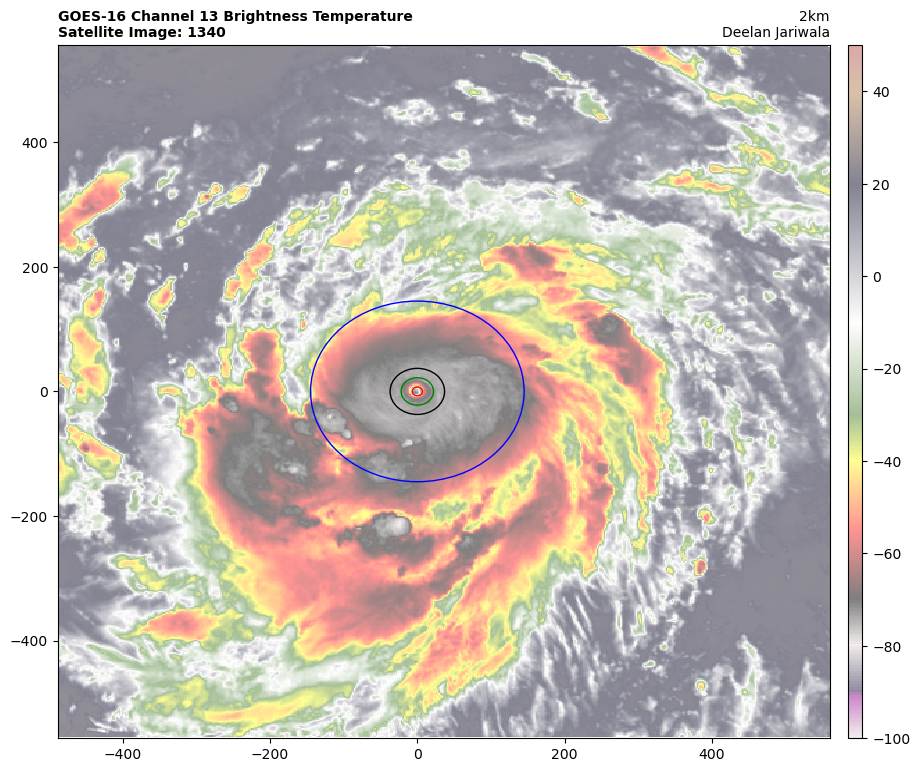

11.215042497082118 -74.02000021547336 -74.02000021547336


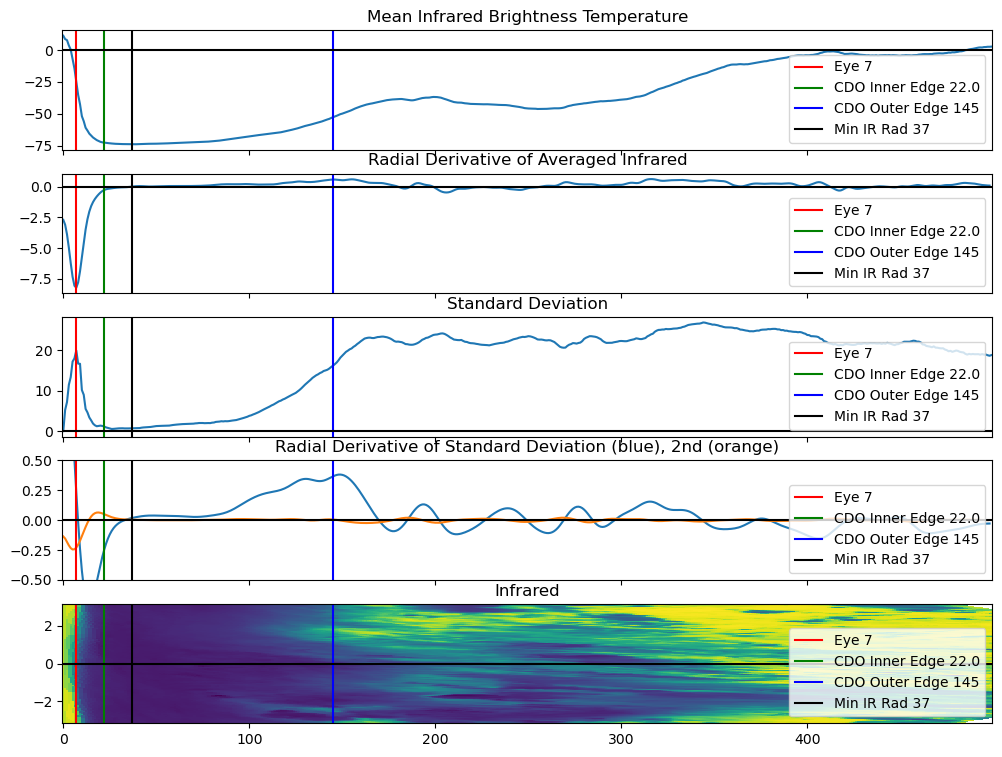

138


In [284]:
from scipy.ndimage import gaussian_filter1d

# polar.values = np.where(polar.values < np.nanmean(polar.values), polar.values, np.nan)

ir_std = np.nanstd(polar.values, axis = 1)
ir_azi = np.nanmean(polar.values, axis = 1)
radii = polar.r.values
min_ir_azi = np.nanmin(ir_azi)

diff = (np.diff(ir_std) / np.diff(radii))
diff = gaussian_filter1d(diff, sigma = 6)

diff2_std = np.diff(diff) / np.diff(radii[1:])
diff2_std = gaussian_filter1d(diff2_std, sigma=2)

diff2 = np.diff(ir_azi) / np.diff(radii)
diff2 = gaussian_filter1d(diff2, sigma = 2)

min_ir_rad = radii[np.nanargmin(ir_azi)]
min_ir_temp = np.nanmin(ir_azi)
eyerad = radii[np.nanargmin(diff2)] 
eyetemp = np.nanmax(ir_azi[radii < min_ir_rad])
icdoedge = (eyerad + min_ir_rad) / 2
tempArray = np.arange(0, 499, dtype = 'float32')

temp = int(icdoedge)
tempArray[0:temp] = np.nan
tempArray[temp:] = diff[temp:]
ocdoedge = radii[np.nanargmax(tempArray)]

tempArray = np.arange(0, 499, dtype = 'float32')
tempArray[0:temp], tempArray[ocdoedge:] = np.nan, np.nan 
tempArray[temp:ocdoedge] = diff2[temp:ocdoedge]
ocdoedge = radii[np.nanargmax(tempArray)]

cdostd = np.nanmean(ir_std[int(icdoedge):int(ocdoedge)])

# print(eyerad)
x, y = 0, 0
    
cmap, vmax, vmin = cmaps.irtables['irg']

plt.figure(figsize = (12, 9))
plt.pcolormesh(xkm, ykm, data, vmin = vmin, vmax = vmax, cmap = cmap, alpha = 0.5)
circle1 = plt.Circle((x, y), eyerad, color='r', fill = False)
plt.gca().add_patch(circle1)
circle1 = plt.Circle((x, y), ocdoedge, color='b', fill = False)
plt.gca().add_patch(circle1)
circle1 = plt.Circle((x, y), icdoedge, color = 'green', fill = False)
plt.gca().add_patch(circle1)
circle1 = plt.Circle((x, y), min_ir_rad , color = 'black', fill = False)
plt.gca().add_patch(circle1)

plt.colorbar(orientation = 'vertical', aspect = 50, pad = .02)
plt.title(f'GOES-16 Channel 13 Brightness Temperature\nSatellite Image: {time}' , fontweight='bold', fontsize=10, loc='left')
plt.title(f'2km\nDeelan Jariwala', fontsize=10, loc='right')
plt.show()

print(eyetemp, np.nanmin(ir_azi), min_ir_temp)

fig, axes = plt.subplots(5, 1, sharex=True, figsize = (12, 9))

axes[0].plot(ir_azi)
axes[1].plot(diff2)
axes[2].plot(ir_std)
axes[3].plot(diff)
axes[3].plot(diff2_std)
axes[3].set_ylim(-0.5, 0.5)
axes[4].pcolormesh(polar.r, polar.theta, polar.values.T)
axes[0].set_title('Mean Infrared Brightness Temperature')
axes[1].set_title('Radial Derivative of Averaged Infrared')
axes[2].set_title('Standard Deviation')
axes[3].set_title('Radial Derivative of Standard Deviation (blue), 2nd (orange)')
axes[4].set_title('Infrared')

# plt.axvline(min_ir_rad[index])
for i in range(len(axes)):
    axes[i].axvline(eyerad, color = 'red', label = f'Eye {round(eyerad, 1)}')
    axes[i].axvline(icdoedge, color = 'green', label = f'CDO Inner Edge {round(icdoedge, 1)}')
    axes[i].axvline(ocdoedge, color = 'blue', label = f'CDO Outer Edge {round(ocdoedge, 1)}')
    axes[i].axvline(min_ir_rad, color = 'black', label = f'Min IR Rad {round(min_ir_rad, 1)}')
    axes[i].legend(loc = 'lower right')
    axes[i].axhline(0, color = 'black')

plt.show()

cdorad = ocdoedge - eyerad
print(np.nanmin(cdorad)) 
# plt.plot(cdorad)
# plt.show()